Compute zenith averaged muon and electron neutrino flux
-----------------------------------------------------------

The down-going neutrino fluxes are averaged over 11 bins in cos(zenith).

In [1]:
#basic imports and ipython setup
#import primary model choices
import crflux.models as pm
import matplotlib.pyplot as plt
import numpy as np

#import solver related modules
from MCEq.core import MCEqRun

In [2]:
mceq_run = MCEqRun(
#provide the string of the interaction model
interaction_model='SIBYLL2.3c',
#primary cosmic ray flux model
#support a tuple (primary model class (not instance!), arguments)
primary_model = (pm.HillasGaisser2012, "H3a"),
# Zenith angle in degrees. 0=vertical, 90=horizontal
theta_deg=0.0,
)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


__________

If everything succeeds than the last message should be something like

`MCEqRun::set_primary_model():  HillasGaisser2012 H3a`.

Define variables and angles
-------------------------

In [3]:
#Power of energy to scale the flux
mag = 3

#obtain energy grid (fixed) of the solution for the x-axis of the plots
e_grid = mceq_run.e_grid

#Dictionary for results
flux = {}

#Define equidistant grid in cos(theta)
angles = np.arccos(np.linspace(1,0,11))*180./np.pi

Calculate average flux
---------------------

In [4]:
#Initialize empty grid
for frac in ['mu_conv','mu_pr','mu_total',
             'numu_conv','numu_pr','numu_total',
             'nue_conv','nue_pr','nue_total','nutau_pr']:
    flux[frac] = np.zeros_like(e_grid)

    
#Sum fluxes, calculated for different angles
for theta in angles:
    mceq_run.set_theta_deg(theta)
    mceq_run.solve()
    #_conv means conventional (mostly pions and kaons)
    flux['mu_conv'] += (mceq_run.get_solution('conv_mu+', mag)
                       + mceq_run.get_solution('conv_mu-', mag))

    # _pr means prompt (the mother of the muon had a critical energy
    # higher than a D meson. Includes all charm and direct resonance
    # contribution)
    flux['mu_pr'] += (mceq_run.get_solution('pr_mu+', mag)
                     + mceq_run.get_solution('pr_mu-', mag))

    # total means conventional + prompt
    flux['mu_total'] += (mceq_run.get_solution('total_mu+', mag)
                        + mceq_run.get_solution('total_mu-', mag))

    # same meaning of prefixes for muon neutrinos as for muons
    flux['numu_conv'] += (mceq_run.get_solution('conv_numu', mag)
                         + mceq_run.get_solution('conv_antinumu', mag))

    flux['numu_pr'] += (mceq_run.get_solution('pr_numu', mag)
                       + mceq_run.get_solution('pr_antinumu', mag))

    flux['numu_total'] += (mceq_run.get_solution('total_numu', mag)
                          + mceq_run.get_solution('total_antinumu', mag))

    # same meaning of prefixes for electron neutrinos as for muons
    flux['nue_conv'] += (mceq_run.get_solution('conv_nue', mag)
                        + mceq_run.get_solution('conv_antinue', mag))

    flux['nue_pr'] += (mceq_run.get_solution('pr_nue', mag)
                      + mceq_run.get_solution('pr_antinue', mag))

    flux['nue_total'] += (mceq_run.get_solution('total_nue', mag)
                         + mceq_run.get_solution('total_antinue', mag))


    # since there are no conventional tau neutrinos, prompt=total
    flux['nutau_pr'] += (mceq_run.get_solution('total_nutau', mag)
                        + mceq_run.get_solution('total_antinutau', mag))

#average the results
for frac in ['mu_conv','mu_pr','mu_total',
             'numu_conv','numu_pr','numu_total',
             'nue_conv','nue_pr','nue_total','nutau_pr']:
    flux[frac] = flux[frac]/float(len(angles))

Plot with matplotlib
--------------------

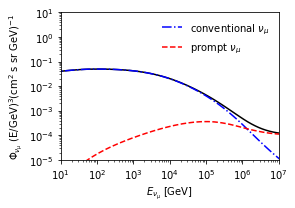

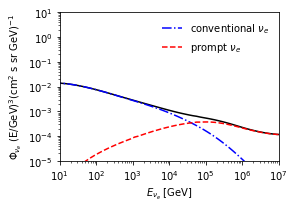

In [8]:
#get path of the home directory + Desktop
save_pdf = False

for pref, lab in [('numu_',r'\nu_\mu'), ('nue_',r'\nu_e')]:
    plt.figure(figsize=(4.2, 3))
    plt.loglog(e_grid, flux[pref + 'total'], color='k', ls='-', lw=1.5)
    plt.loglog(e_grid, flux[pref + 'conv'], color='b', ls='-.', lw=1.5,
               label=rf'conventional ${lab}$')
    plt.loglog(e_grid, flux[pref + 'pr'], color='r',ls='--', lw=1.5, 
               label=f'prompt ${lab}$')
    plt.xlim(10,1e7)
    plt.ylim(1e-5,10)
    plt.xlabel(rf"$E_{{{lab}}}$ [GeV]")
    plt.ylabel(r"$\Phi_{" + lab + "}$ (E/GeV)$^{" + str(mag) +" }$" + 
               "(cm$^{2}$ s sr GeV)$^{-1}$")
    plt.legend(loc='upper right',frameon=False,numpoints=1,fontsize='medium')
    plt.tight_layout()
    if save_pdf:
        import os
        plt.savefig(os.path.join(os.path.expanduser("~"),'Desktop', pref + 'flux.png'),dpi=300)

Save as in ASCII file for other types of processing
---------------------------------------------------

In [7]:
np.savetxt(open(os.path.join(desktop, 'H3a_zenith_av.txt'),'w'),
zip(e_grid, 
    flux['mu_conv'],flux['mu_pr'],flux['mu_total'],
    flux['numu_conv'],flux['numu_pr'],flux['numu_total'],
    flux['nue_conv'],flux['nue_pr'],flux['nue_total'],
    flux['nutau_pr']),
fmt='%6.5E',
header=('lepton flux scaled with E**{0}. Order (E, mu_conv, mu_pr, mu_total, ' +
        'numu_conv, numu_pr, numu_total, nue_conv, nue_pr, nue_total, ' +
        'nutau_pr').format(mag)
)